In [1]:
!pip install fastavro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Note that `output_A.avro` is a smaller file with lesser songs; while `output_A2Z.avro` contains all available songs.

In [ ]:
import fastavro
import numpy as np
import pandas as pd

# Load your .avro file
with open('/content/output_A.avro', 'rb') as f:
    records = [r for r in fastavro.reader(f)]

# Convert to DataFrame
df = pd.DataFrame(records)

df.head(3)

,bars_confidence_mean,bars_confidence_std,bars_confidence_max,beats_confidence_mean,beats_confidence_std,beats_confidence_max,sections_confidence_mean,sections_confidence_std,sections_confidence_max,segments_confidence_mean,...,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_latitude,artist_longitude,artist_playmeid,release_7digitalid,song_hotttnesss,track_7digitalid,year
0,0.117149,0.153265,0.682,0.376149,0.195741,0.801,0.558667,0.298345,1.0,0.402875,...,324573,0.639903,0.461318,NaN,NaN,166043,497103,0.733372,5504670,2009
1,0.121100,0.152361,0.819,0.000000,0.000000,0.000,0.578714,0.316845,1.0,0.400524,...,173942,0.671755,0.386606,37.77916,-122.42005,38879,226813,0.481694,2496043,2005
2,0.172096,0.256234,0.994,0.611462,0.157866,0.858,0.477100,0.304732,1.0,0.696677,...,165270,0.581794,0.401998,NaN,NaN,4479,300848,0.602120,3401791,0


I tried some year analysis before and the distribution of data is extremely uneven. Let's apply data balancing.

Mean Squared Error: 461.09
Mean Absolute Error: 8.74 years
R-squared: 0.29


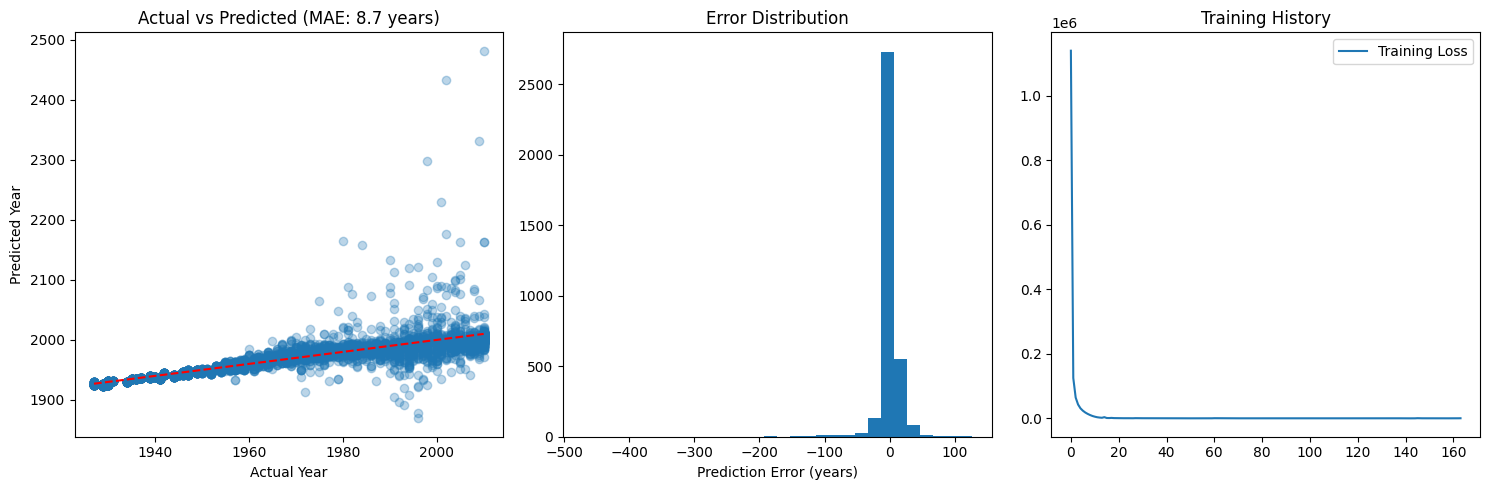

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Data Loading and Preparation (use your existing loading code)
def load_specific_columns(file_path, columns_needed):
    """Load only specific columns from avro file"""
    data = []
    with open(file_path, 'rb') as f:
        avro_reader = fastavro.reader(f)
        for record in avro_reader:
            filtered_record = {col: record[col] for col in columns_needed}
            data.append(filtered_record)
    df = pd.DataFrame(data)
    df = df[(df['year'] != 0) & (df['year'].notna())]
    return df

# Load the data
needed_columns = ['segments_timbre', 'year']
filtered_data = load_specific_columns('/content/output_A.avro', needed_columns)

# Prepare features and target
timbre_features = pd.DataFrame(filtered_data['segments_timbre'].tolist(),
                            columns=[f'timbre_{i}' for i in range(90)])
years = filtered_data['year'].astype(float)

# Data Balancing Function
def balance_data(X, y, target_range=(1900, 2020), bin_size=5, samples_per_bin=1000):
    """Resample data to balance year distribution"""
    bins = np.arange(target_range[0], target_range[1] + bin_size, bin_size)
    y_binned = np.digitize(y, bins)

    balanced_X = []
    balanced_y = []

    for bin_num in np.unique(y_binned):
        idx = np.where(y_binned == bin_num)[0]

        if len(idx) > samples_per_bin:
            idx = np.random.choice(idx, samples_per_bin, replace=False)
        else:
            idx = resample(idx, replace=True, n_samples=samples_per_bin, random_state=42)

        balanced_X.append(X.iloc[idx])
        balanced_y.append(y.iloc[idx])

    return pd.concat(balanced_X), pd.concat(balanced_y)

# Balance the dataset
X_balanced, y_balanced = balance_data(timbre_features, years)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42)

# Feature Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Enhanced MLP Model
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=128,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.15,
    max_iter=1000,
    random_state=42,
    n_iter_no_change=20
)

# 8. Training
history = mlp.fit(X_train_scaled, y_train)

# 9. Evaluation
y_pred = mlp.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f} years")
print(f"R-squared: {r2:.2f}")

# 10. Visualization
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Actual Year')
plt.ylabel('Predicted Year')
plt.title(f'Actual vs Predicted (MAE: {mae:.1f} years)')

# Error Distribution
plt.subplot(1, 3, 2)
errors = y_test - y_pred
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error (years)')
plt.title('Error Distribution')

# Training Curve
plt.subplot(1, 3, 3)
plt.plot(history.loss_curve_, label='Training Loss')
plt.legend()
plt.title('Training History')

plt.tight_layout()
plt.show()

Based on the reuslt, the spread of predicted year can be < 1924 and > 2020 which are out of the dataset's year range. So I have a custom output layer, clipping the output, and return the preidction of year as `int`. The return year can be `float` if set `return_float=True`.

Mean Squared Error: 52.10
Mean Absolute Error: 3.83 years
R-squared: 0.92


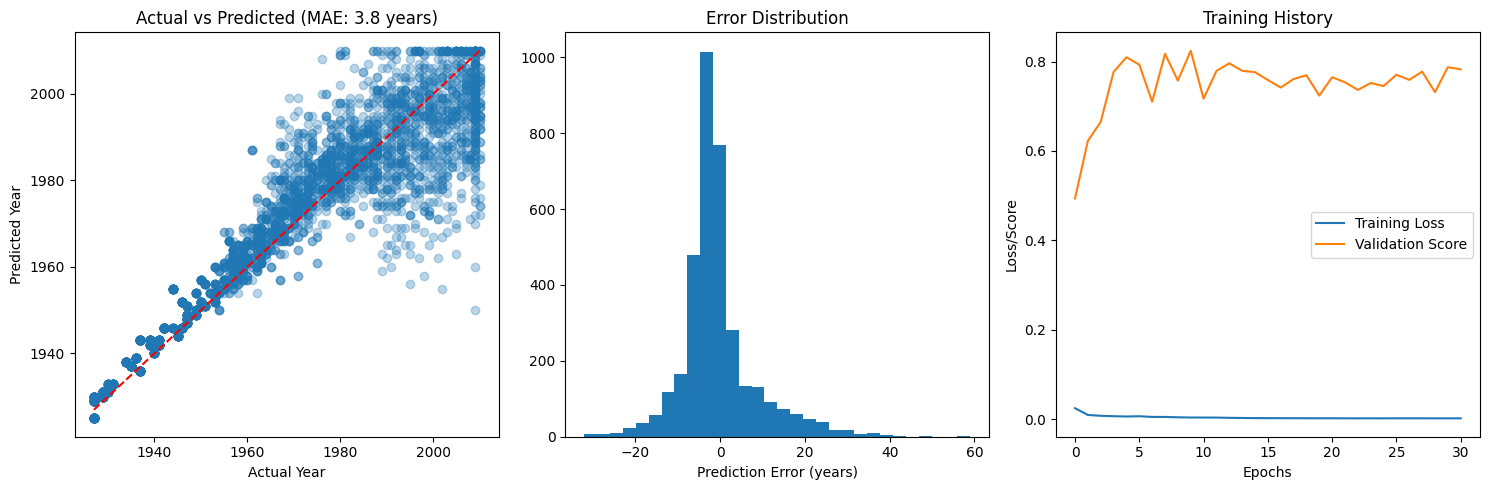

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin

class ConstrainedMLP(BaseEstimator, RegressorMixin):
  #  Create a custom output layer
    def __init__(self, min_year=1924, max_year=2010, **mlp_kwargs):
        self.min_year = min_year
        self.max_year = max_year
        self.mlp = MLPRegressor(**mlp_kwargs)

    def fit(self, X, y):
        # Scale y to [0,1] range 
        self.y_min_, self.y_max_ = self.min_year, self.max_year
        y_scaled = (y - self.y_min_) / (self.y_max_ - self.y_min_)
        self.mlp.fit(X, y_scaled)
         # Expose training history attributes
        self.loss_curve_ = self.mlp.loss_curve_
        if hasattr(self.mlp, 'validation_scores_'):
            self.validation_scores_ = self.mlp.validation_scores_
        return self

    def predict(self, X, return_float=False):
        """Returns integer predictions by default"""
        y_pred_scaled = self.mlp.predict(X)
        y_pred = y_pred_scaled * (self.max_year - self.min_year) + self.min_year
        y_pred = np.clip(y_pred, self.min_year, self.max_year)
        return y_pred if return_float else np.ceil(y_pred).astype(int)

# Enhanced MLP Model
mlp = ConstrainedMLP(
    min_year=1920,
    max_year=2010,
    hidden_layer_sizes=(256, 128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=128,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.15,
    max_iter=1000,
    random_state=42,
    n_iter_no_change=20
)

mlp.fit(X_train_scaled, y_train)

# Evaluation
# Get integer predictions
y_pred_int = mlp.predict(X_test_scaled)
# y_pred_float = mlp.predict(X_test_scaled, return_float=True)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f} years")
print(f"R-squared: {r2:.2f}")

# 10. Visualization
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_int, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Actual Year')
plt.ylabel('Predicted Year')
plt.title(f'Actual vs Predicted (MAE: {mae:.1f} years)')

# Error Distribution
plt.subplot(1, 3, 2)
errors = y_test - y_pred_int
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error (years)')
plt.title('Error Distribution')

# Training Curve
plt.subplot(1, 3, 3)
plt.plot(mlp.loss_curve_, label='Training Loss')
if hasattr(mlp, 'validation_scores_'):
    plt.plot(mlp.validation_scores_, label='Validation Score')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Score')
plt.title('Training History')

plt.tight_layout()
plt.show()

The result is so much better now. But keep in mind that this is using partial data to train.